In [1]:
from numpy import sqrt, abs, pi, cos, sin, max, ones, array
from astropy import coordinates
from astropy import units as u
from astropy.coordinates import SkyCoord
import numpy as np

def kdist(l, b, vin, near=True,r0=8.31e3,v0=2.54e2,dynamical=False,
        kinematic=True,regular=False,rrgal=False,verbose=True,
        inverse=False,silent=False, returnvtan=False):
    '''Calculates kinematic distance.
    Translated from IDL to Python by Adam Ginsburg
    
    Inputs:
    l: Galactic longitude (decimal degrees)
    b: Galactic latitude (decimal degrees)
    vin: radial velocity wrt LSR (km/s)
    r0: galactocentric distance for sun (pc; 8.4e3, Reid et al. 2009)
    v0: velocity of LSR around GC (km/s; 240, Reid et al. 2009)
    dynamical: Use the dynamical definition of the LSR (bool)
    kinematic: Use the kinematic definition of the LSR (bool; default)
    regular: Do not apply the rotation correction for High mass star forming regions (bool)
    rrgal: return galactocentric distance in addition to distance from us (bool)
    inverse: If set, pass DISTANCE instead of velocity, and output is velocity (bool)
    returnvtan: If set, return the tanent velocity and ignore the input velocity (bool)
    
    Output:
    dist: kinematic distance in pc
    '''

    dtor = pi/180.

    if regular: vs = 0.0 
    else: vs=15.0

    if kinematic or not(dynamical):
        solarmotion_ra = ((18+3/6e1+50.29/3.6e3)*15)
        solarmotion_dec = (30+0/6e1+16.8/3.6e3)
        solarmotion_mag = 20.0
    else:
        solarmotion_ra = ((17+49/6e1+58.667/3.6e3)*15)
        solarmotion_dec = (28+7/6e1+3.96/3.6e3)
        solarmotion_mag = 16.55294

    #cg = coordinates.Galactic(l,b,unit=('deg','deg'))
    cg = SkyCoord(l*u.deg, b*u.deg, frame='galactic')
    #solarmotion = coordinates.ICRS(solarmotion_ra, solarmotion_dec, unit=('deg','deg'))
    solarmotion = SkyCoord(ra=solarmotion_ra*u.deg, dec=solarmotion_dec*u.deg, frame='icrs')
    #  ra,dec = cg.j2000()
    #  gcirc, 2, solarmotion_ra, solarmotion_dec, ra, dec, theta
    theta = cg.separation(solarmotion).to('arcsec').value

    vhelio = vin-solarmotion_mag*cos(theta/206265.)
    #vhelio=vin
    
    # UVW from Dehnen and Binney
    bigu = 9.96
    bigv = 5.25
    bigw = 7.07

    v = vhelio+(bigu*cos(l*dtor)+bigv*sin(l*dtor))*cos(b*dtor)+bigw*sin(b*dtor)

    # Compute tangent distance and velocity
    rtan = r0*(cos(l*dtor))/(cos(b*dtor))
    vTEMP = (1/sin(l*dtor) - v0/(v0-vs)) * ((v0-vs)*sin(l*dtor)*cos(b*dtor))
    vhelioTEMP = vTEMP - ((bigu*cos(l*dtor)+bigv*sin(l*dtor))*cos(b*dtor)+bigw*sin(b*dtor))
    vtan = vhelioTEMP+solarmotion_mag*cos(theta/206265.)
    if returnvtan:
        return vtan

    # This is r/r0
    null = (v0/(v0-vs)+v/((v0-vs)*sin(l*dtor)*cos(b*dtor)))**(-1)

    if inverse:
        radical = cos(l*dtor) - cos(b*dtor) * vin / r0 
        null = sqrt(1 - cos(l*dtor)**2 + radical**2)
        v = (1/null - v0/(v0-vs)) * ((v0-vs)*sin(l*dtor)*cos(b*dtor))
        vhelio = v - ((bigu*cos(l*dtor)+bigv*sin(l*dtor))*cos(b*dtor)+bigw*sin(b*dtor))
        vlsr = vhelio+solarmotion_mag*cos(theta/206265.)
        return vlsr
    else:
        if vin > vtan:
            if not silent:
                print("Velocity is greater than tangent velocity v=%f.  Returning tangent distance." % vtan)
            if rrgal: return rtan,null*r0
            return rtan
        #  The > 0 traps things near the tangent point and sets them to the
        #  tangent distance.  So quietly.  Perhaps this should pitch a flag?
        radical = max(sqrt(((cos(l*dtor))**2-(1-null**2)) ),0)

        fardist = r0*(cos(l*dtor)+radical)/(cos(b*dtor))

        neardist = r0*(cos(l*dtor)-radical)/(cos(b*dtor))

    rgal = null*r0
    ind = (abs(l-180) < 90)
    if ind.sum() > 1: neardist[ind] = fardist[ind]
    elif ind==True: neardist = fardist

    if not(near): dist = fardist
    else: dist = neardist

    if verbose:
        print("radical: %f  null: %f  vin: %f  v: %f  vhelio: %f rgal: %f  neardist: %f  fardist: %f" % (radical,null,vin,v,vhelio,rgal,neardist,fardist))

    if rrgal: return abs(dist),abs(rgal)
    return abs(dist)

c = SkyCoord(ra='13h48m12.739s', dec='-63d16m24.7s', frame='icrs')


c_gal=c.galactic
L=float(c_gal.l.deg)
B=float(c_gal.b.deg)
V=(-46.5098)
dist = kdist(L, B, V,rrgal=True,near=False,verbose=True)
print(L,B)
print(dist)
print('Source has a kinematic distance of line 1: ',dist[0]/1e3, 'kpc')

radical: 0.132731  null: 0.785531  vin: -46.509800  v: -38.900387  vhelio: -41.002928 rgal: 6527.760612  neardist: 4157.150783  fardist: 6363.547155
309.26420137783083 -1.1019256204949412
(6363.547154928355, 6527.760612272414)
Source has a kinematic distance of line 1:  6.363547154928355 kpc


/var/folders/2l/vhjdf14d2vjd4qffvsk5p19r0000gq/T/ipykernel_60106/2666290925.py:88: RuntimeWarning: invalid value encountered in sqrt
  radical = max(sqrt(((cos(l*dtor))**2-(1-null**2)) ),0)


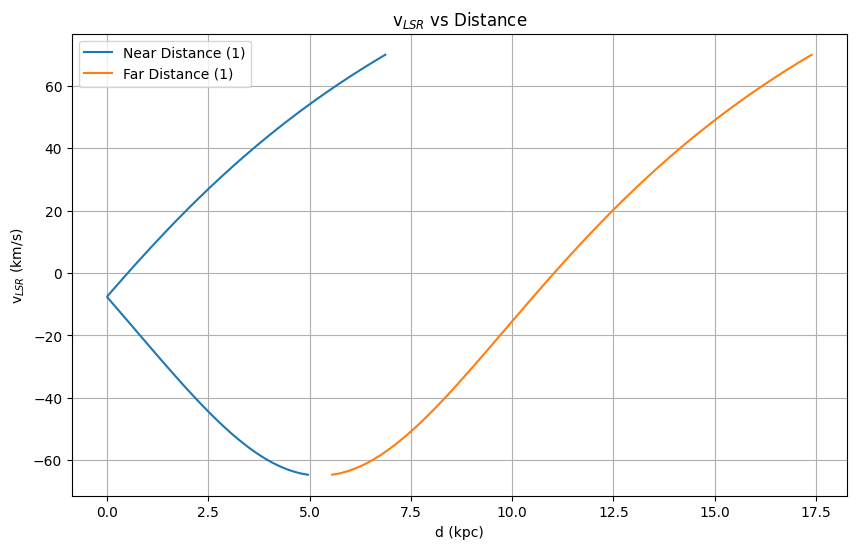

In [2]:
import matplotlib.pyplot as plt

# Define a range of velocities (V_LSR)
velocities = np.linspace(-70, 70, 500)  # Adjust range and step as needed

# Calculate distances for each velocity
distancesnear = []
distancesfar=[]
for v in velocities:
    try:
        dist = kdist(L, B, v, rrgal=False, near=False,  regular=True, verbose=False)
        distancesfar.append(dist)
    except Exception as e:
        # Handle cases where kdist might fail
        print(f"Error for velocity {v}: {e}")
        distancesfar.append(np.nan)
        
for v in velocities:
    try:
        dist = kdist(L, B, v, rrgal=False, near=True, regular=True, verbose=False)
        distancesnear.append(dist)
    except Exception as e:
        # Handle cases where kdist might fail
        print(f"Error for velocity {v}: {e}")
        distancesnear.append(np.nan)
    
# Convert distances to a numpy array for plotting
distancesfar1 = np.array(distancesfar)
distancesnear1 = np.array(distancesnear)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(distancesnear1/1e3, velocities, label='Near Distance (1)')
plt.plot(distancesfar1/1e3, velocities, label='Far Distance (1)')
plt.xlabel('d (kpc)')
plt.ylabel('v$_{LSR}$ (km/s)')
plt.title('v$_{LSR}$ vs Distance')
plt.grid(True)
plt.legend()
plt.show()

In [3]:
for i in range(0,500):
    print(distancesnear [i], velocities[i])

nan -70.0
nan -69.71943887775551
nan -69.43887775551102
nan -69.15831663326654
nan -68.87775551102204
nan -68.59719438877755
nan -68.31663326653306
nan -68.03607214428858
nan -67.75551102204409
nan -67.4749498997996
nan -67.1943887775551
nan -66.91382765531063
nan -66.63326653306613
nan -66.35270541082164
nan -66.07214428857715
nan -65.79158316633267
nan -65.51102204408818
nan -65.23046092184369
nan -64.9498997995992
4961.409340953208 -64.66933867735472
4834.541375016764 -64.38877755511022
4737.314333030816 -64.10821643286573
4655.265809585632 -63.82765531062124
4582.857514151262 -63.547094188376754
4517.265037717103 -63.26653306613227
4456.816652400106 -62.985971943887776
4400.426050847179 -62.705410821643284
4347.340288964513 -62.4248496993988
4297.012131517483 -62.144288577154306
4249.0291009173525 -61.86372745490982
4203.071186372576 -61.58316633266533
4158.88422011965 -61.30260521042084
4116.262362942004 -61.02204408817635
4075.0361573198575 -60.741482965931866
4035.06412711293 -6

In [4]:
c = SkyCoord(ra='13h48m12.739s', dec='-63d16m24.7s', frame='icrs')


c_gal=c.galactic
L=float(c_gal.l.deg)
B=float(c_gal.b.deg)
V=(-52.9447)
dist = kdist(L, B, V,rrgal=True,near=False,verbose=True, regular=False)
print(L,B)
print(dist)
print('Source has a kinematic distance of line 2: ',dist[0]/1e3, 'kpc')

radical: nan  null: 0.764639  vin: -52.944700  v: -45.335287  vhelio: -47.437828 rgal: 6354.151803  neardist: nan  fardist: nan
309.26420137783083 -1.1019256204949412
(nan, 6354.15180287546)
Source has a kinematic distance of line 2:  nan kpc


/var/folders/2l/vhjdf14d2vjd4qffvsk5p19r0000gq/T/ipykernel_60106/2666290925.py:88: RuntimeWarning: invalid value encountered in sqrt
  radical = max(sqrt(((cos(l*dtor))**2-(1-null**2)) ),0)


In [5]:
c = SkyCoord(ra='13h48m12.739s', dec='-63d16m24.7s', frame='icrs')


c_gal=c.galactic
L=float(c_gal.l.deg)
B=float(c_gal.b.deg)
V=(-60.247)
dist = kdist(L, B, V,rrgal=True,near=False,verbose=True)
print(L,B)
print(dist)
print('Source has a kinematic distance of line 3: ',dist[0]/1e3, 'kpc')

radical: nan  null: 0.742238  vin: -60.247000  v: -52.637587  vhelio: -54.740128 rgal: 6167.998949  neardist: nan  fardist: nan
309.26420137783083 -1.1019256204949412
(nan, 6167.998948826313)
Source has a kinematic distance of line 3:  nan kpc


/var/folders/2l/vhjdf14d2vjd4qffvsk5p19r0000gq/T/ipykernel_60106/2666290925.py:88: RuntimeWarning: invalid value encountered in sqrt
  radical = max(sqrt(((cos(l*dtor))**2-(1-null**2)) ),0)


In [6]:
c = SkyCoord(ra='13h48m12.739s', dec='-63d16m24.7s', frame='icrs')


c_gal=c.galactic
L=float(c_gal.l.deg)
B=float(c_gal.b.deg)
V=(50.0)
dist = kdist(L, B, V,rrgal=True,near=False,verbose=True)
print(L,B)
print(dist)
print('Source has a kinematic distance of line 4: ',dist[0]/1e3, 'kpc')

radical: 1.082518  null: 1.330897  vin: 50.000000  v: 57.609413  vhelio: 55.506872 rgal: 11059.753746  neardist: -3737.041183  fardist: 14257.739121
309.26420137783083 -1.1019256204949412
(14257.739121161778, 11059.753746003798)
Source has a kinematic distance of line 4:  14.257739121161778 kpc


In [7]:
c = SkyCoord(ra='13h48m12.739s', dec='-63d16m24.7s', frame='icrs')


c_gal=c.galactic
L=float(c_gal.l.deg)
B=float(c_gal.b.deg)
V=(-31.4)
dist = kdist(L, B, V,rrgal=True,near=False,verbose=True, regular=False)
print(L,B)
print(dist)
print('Source has a kinematic distance of test: ',dist[0]/1e3, 'kpc')

radical: 0.324222  null: 0.839381  vin: -31.400000  v: -23.790587  vhelio: -25.893128 rgal: 6975.258944  neardist: 2565.565018  fardist: 7955.132919
309.26420137783083 -1.1019256204949412
(7955.132919309851, 6975.258944351372)
Source has a kinematic distance of test:  7.955132919309851 kpc


In [8]:
def kdist(l, b, vin, near=True, r0=8.4e3, v0=2.54e2, dynamical=False,
          kinematic=True, regular=False, rrgal=False, verbose=True,
          inverse=False, silent=False, returnvtan=False):
    '''Calculates kinematic distance.'''

    dtor = pi / 180.

    if regular:
        vs = 0.0
    else:
        vs = 15.0

    if kinematic or not dynamical:
        solarmotion_ra = (18 + 3/60 + 50.29/3600) * 15
        solarmotion_dec = 30 + 0/60 + 16.8/3600
        solarmotion_mag = 20.0
    else:
        solarmotion_ra = (17 + 49/60 + 58.667/3600) * 15
        solarmotion_dec = 28 + 7/60 + 3.96/3600
        solarmotion_mag = 16.55294

    cg = SkyCoord(l * u.deg, b * u.deg, frame='galactic')
    solarmotion = SkyCoord(ra=solarmotion_ra * u.deg, dec=solarmotion_dec * u.deg, frame='icrs')
    theta = cg.separation(solarmotion).arcsecond

    vhelio = vin - solarmotion_mag * cos(theta / 206265)

    bigu, bigv, bigw = 10.0, 5.23, 7.17

    v = (vhelio + (bigu * cos(l * dtor) + bigv * sin(l * dtor)) * cos(b * dtor) + bigw * sin(b * dtor))

    rtan = r0 * (cos(l * dtor)) / (cos(b * dtor))
    vtan = v0 * sin(l * dtor) * cos(b * dtor)

    if returnvtan:
        return vtan

    null = (v0 / (v0 - vs) + v / ((v0 - vs) * sin(l * dtor) * cos(b * dtor)))**(-1)

    radical_term = (cos(l * dtor))**2 - (1 - null**2)
    if radical_term < 0:
        if verbose:
            print("Warning: radical term is negative, setting radical to zero.")
        radical = 0
    else:
        radical = sqrt(radical_term)

    fardist = r0 * (cos(l * dtor) + radical) / (cos(b * dtor))
    neardist = r0 * (cos(l * dtor) - radical) / (cos(b * dtor))

    rgal = null * r0
    if abs(l - 180) < 90:
        neardist = fardist

    dist = neardist if near else fardist

    if verbose:
        print(f"radical: {radical:.2f}, null: {null:.2f}, vin: {vin:.2f}, v: {v:.2f}, "
              f"vhelio: {vhelio:.2f}, rgal: {rgal:.2f}, neardist: {neardist:.2f}, fardist: {fardist:.2f}")

    if rrgal:
        return abs(dist), abs(rgal)
    return abs(dist)

c = SkyCoord(ra='13h48m12.739s', dec='-63d16m24.7s', frame='icrs')


c_gal=c.galactic
L=float(c_gal.l.deg)
B=float(c_gal.b.deg)
V=(-52.9447)
dist = kdist(L, B, V,rrgal=True,near=False,verbose=True, regular=False)
print(L,B)
print(dist)
print('Source has a kinematic distance of line 2: ',dist[0]/1e3, 'kpc')


radical: 0.00, null: 0.76, vin: -52.94, v: -45.30, vhelio: -47.44, rgal: 6424.00, neardist: 5317.32, fardist: 5317.32
309.26420137783083 -1.1019256204949412
(5317.320257320709, 6424.00134500256)
Source has a kinematic distance of line 2:  5.317320257320709 kpc


In [9]:
from numpy import sqrt, abs, pi, cos, sin, max, ones, array
from astropy import coordinates
from astropy import units as u
from astropy.coordinates import SkyCoord
import numpy as np

def kdist(l, b, vin, near=True,r0=8.31e3,v0=2.41e2,dynamical=False,
        kinematic=True,regular=False,rrgal=False,verbose=True,
        inverse=False,silent=False, returnvtan=False):
    '''Calculates kinematic distance.
    Translated from IDL to Python by Adam Ginsburg
    
    Inputs:
    l: Galactic longitude (decimal degrees)
    b: Galactic latitude (decimal degrees)
    vin: radial velocity wrt LSR (km/s)
    r0: galactocentric distance for sun (pc; 8.4e3, Reid et al. 2009)
    v0: velocity of LSR around GC (km/s; 240, Reid et al. 2009)
    dynamical: Use the dynamical definition of the LSR (bool)
    kinematic: Use the kinematic definition of the LSR (bool; default)
    regular: Do not apply the rotation correction for High mass star forming regions (bool)
    rrgal: return galactocentric distance in addition to distance from us (bool)
    inverse: If set, pass DISTANCE instead of velocity, and output is velocity (bool)
    returnvtan: If set, return the tanent velocity and ignore the input velocity (bool)
    
    Output:
    dist: kinematic distance in pc
    '''

    dtor = pi/180.

    if regular: vs = 0.0 
    else: vs=15.0

    if kinematic or not(dynamical):
        solarmotion_ra = ((18+3/6e1+50.29/3.6e3)*15)
        solarmotion_dec = (30+0/6e1+16.8/3.6e3)
        solarmotion_mag = 20.0
    else:
        solarmotion_ra = ((17+49/6e1+58.667/3.6e3)*15)
        solarmotion_dec = (28+7/6e1+3.96/3.6e3)
        solarmotion_mag = 16.55294

    #cg = coordinates.Galactic(l,b,unit=('deg','deg'))
    cg = SkyCoord(l*u.deg, b*u.deg, frame='galactic')
    #solarmotion = coordinates.ICRS(solarmotion_ra, solarmotion_dec, unit=('deg','deg'))
    solarmotion = SkyCoord(ra=solarmotion_ra*u.deg, dec=solarmotion_dec*u.deg, frame='icrs')
    #  ra,dec = cg.j2000()
    #  gcirc, 2, solarmotion_ra, solarmotion_dec, ra, dec, theta
    theta = cg.separation(solarmotion).to('arcsec').value

    vhelio = vin-solarmotion_mag*cos(theta/206265.)
    #vhelio=vin
    
    # UVW from Dehnen and Binney
    #bigu = 9.96
    #bigv = 5.25
    #bigw = 7.07
    
    #UVW from Reid (2014)
    bigu = 10.5
    bigv = 14.4
    bigw = 8.9
    
    v = vhelio+(bigu*cos(l*dtor)+bigv*sin(l*dtor))*cos(b*dtor)+bigw*sin(b*dtor)

    # Compute tangent distance and velocity
    rtan = r0*(cos(l*dtor))/(cos(b*dtor))
    vTEMP = (1/sin(l*dtor) - v0/(v0-vs)) * ((v0-vs)*sin(l*dtor)*cos(b*dtor))
    vhelioTEMP = vTEMP - ((bigu*cos(l*dtor)+bigv*sin(l*dtor))*cos(b*dtor)-bigw*sin(b*dtor))
    vtan = vhelioTEMP+solarmotion_mag*cos(theta/206265.)
    if returnvtan:
        return vtan

    # This is r/r0
    null = (v0/(v0-vs)+v/((v0-vs)*sin(l*dtor)*cos(b*dtor)))**(-1)

    if inverse:
        radical = cos(l*dtor) - cos(b*dtor) * vin / r0 
        null = sqrt(1 - cos(l*dtor)**2 + radical**2)
        v = (1/null - v0/(v0-vs)) * ((v0-vs)*sin(l*dtor)*cos(b*dtor))
        vhelio = v - ((bigu*cos(l*dtor)+bigv*sin(l*dtor))*cos(b*dtor)+bigw*sin(b*dtor))
        vlsr = vhelio+solarmotion_mag*cos(theta/206265.)
        return vlsr
    else:
        if vin > vtan:
            if not silent:
                print("Velocity is greater than tangent velocity v=%f.  Returning tangent distance." % vtan)
            if rrgal: return rtan,null*r0
            return rtan
        #  The > 0 traps things near the tangent point and sets them to the
        #  tangent distance.  So quietly.  Perhaps this should pitch a flag?
        radical = max(sqrt(((cos(l*dtor))**2-(1-null**2)) ),0)

        fardist = r0*(cos(l*dtor)+radical)/(cos(b*dtor))

        neardist = r0*(cos(l*dtor)-radical)/(cos(b*dtor))

    rgal = null*r0
    ind = (abs(l-180) < 90)
    if ind.sum() > 1: neardist[ind] = fardist[ind]
    elif ind==True: neardist = fardist

    if not(near): dist = fardist
    else: dist = neardist

    if verbose:
        print("radical: %f  null: %f  vin: %f  v: %f  vhelio: %f rgal: %f  neardist: %f  fardist: %f" % (radical,null,vin,v,vhelio,rgal,neardist,fardist))

    if rrgal: return abs(dist),abs(rgal)
    return abs(dist)

c = SkyCoord(ra='13h48m12.739s', dec='-63d16m24.7s', frame='icrs')


c_gal=c.galactic
L=float(c_gal.l.deg)
B=float(c_gal.b.deg)
V=(-46.5098)
dist = kdist(L, B, V,rrgal=True,near=False,verbose=True)
print(L,B)
print(dist)
print('Source has a kinematic distance of line 1: ',dist[0]/1e3, 'kpc')

radical: nan  null: 0.753316  vin: -46.509800  v: -45.676826  vhelio: -41.002928 rgal: 6260.055461  neardist: nan  fardist: nan
309.26420137783083 -1.1019256204949412
(nan, 6260.055460781837)
Source has a kinematic distance of line 1:  nan kpc


/var/folders/2l/vhjdf14d2vjd4qffvsk5p19r0000gq/T/ipykernel_60106/1011220137.py:93: RuntimeWarning: invalid value encountered in sqrt
  radical = max(sqrt(((cos(l*dtor))**2-(1-null**2)) ),0)


/var/folders/2l/vhjdf14d2vjd4qffvsk5p19r0000gq/T/ipykernel_60106/1011220137.py:93: RuntimeWarning: invalid value encountered in sqrt
  radical = max(sqrt(((cos(l*dtor))**2-(1-null**2)) ),0)


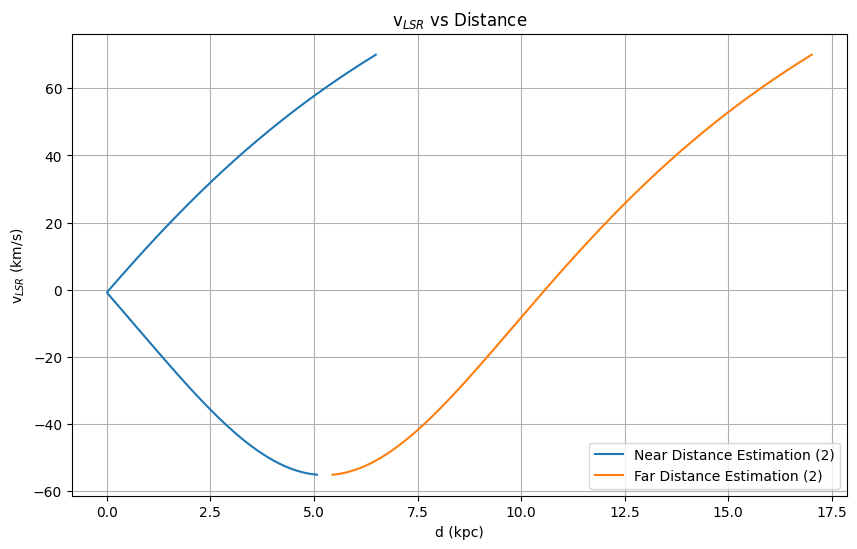

In [10]:
import matplotlib.pyplot as plt

# Define a range of velocities (V_LSR)
velocities = np.linspace(-70, 70, 500)  # Adjust range and step as needed

# Calculate distances for each velocity
distancesnear = []
distancesfar=[]
for v in velocities:
    try:
        dist = kdist(L, B, v, rrgal=False, near=False, regular=True, verbose=False)
        distancesfar.append(dist)
    except Exception as e:
        # Handle cases where kdist might fail
        print(f"Error for velocity {v}: {e}")
        distancesfar.append(np.nan)
        
for v in velocities:
    try:
        dist = kdist(L, B, v, rrgal=False, near=True, regular=True, verbose=False)
        distancesnear.append(dist)
    except Exception as e:
        # Handle cases where kdist might fail
        print(f"Error for velocity {v}: {e}")
        distancesnear.append(np.nan)
    
# Convert distances to a numpy array for plotting
distancesfar2 = np.array(distancesfar)
distancesnear2 = np.array(distancesnear)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(distancesnear2/1e3, velocities, label='Near Distance Estimation (2)')
plt.plot(distancesfar2/1e3, velocities, label='Far Distance Estimation (2)')
plt.xlabel('d (kpc)')
plt.ylabel('v$_{LSR}$ (km/s)')
plt.title('v$_{LSR}$ vs Distance')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
for i in range (0,500):
    print(velocities[i], distancesfar[i])

-70.0 nan
-69.71943887775551 nan
-69.43887775551102 nan
-69.15831663326654 nan
-68.87775551102204 nan
-68.59719438877755 nan
-68.31663326653306 nan
-68.03607214428858 nan
-67.75551102204409 nan
-67.4749498997996 nan
-67.1943887775551 nan
-66.91382765531063 nan
-66.63326653306613 nan
-66.35270541082164 nan
-66.07214428857715 nan
-65.79158316633267 nan
-65.51102204408818 nan
-65.23046092184369 nan
-64.9498997995992 nan
-64.66933867735472 nan
-64.38877755511022 nan
-64.10821643286573 nan
-63.82765531062124 nan
-63.547094188376754 nan
-63.26653306613227 nan
-62.985971943887776 nan
-62.705410821643284 nan
-62.4248496993988 nan
-62.144288577154306 nan
-61.86372745490982 nan
-61.58316633266533 nan
-61.30260521042084 nan
-61.02204408817635 nan
-60.741482965931866 nan
-60.46092184368737 nan
-60.18036072144289 nan
-59.899799599198396 nan
-59.61923847695391 nan
-59.33867735470942 nan
-59.058116232464926 nan
-58.77755511022044 nan
-58.496993987975955 nan
-58.21643286573146 nan
-57.93587174348697 n

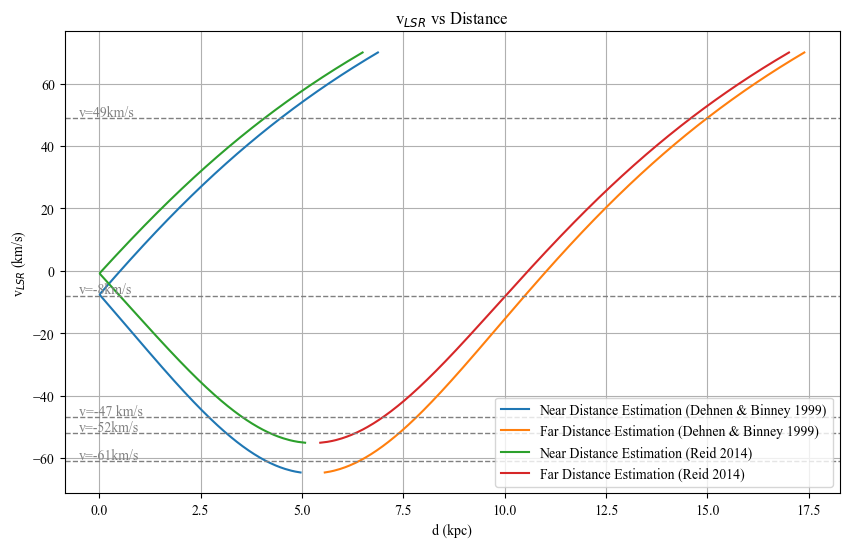

Figure saved as kinDistPlot.pdf


In [13]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
# Your existing data and plot
fig = plt.figure(figsize=(10, 6))
plt.plot(distancesnear1 / 1e3, velocities, label='Near Distance Estimation (Dehnen & Binney 1999)')
plt.plot(distancesfar1 / 1e3, velocities, label='Far Distance Estimation (Dehnen & Binney 1999)')
plt.plot(distancesnear2 / 1e3, velocities, label='Near Distance Estimation (Reid 2014)')
plt.plot(distancesfar2 / 1e3, velocities, label='Far Distance Estimation (Reid 2014)')

# Add horizontal lines with labels
horizontal_positions = [-47, -52, 49, -8, -61]
labels = ['v=-47 km/s', 'v=-52km/s', 'v=49km/s', 'v=-8km/s', 'v=-61km/s']

for y_pos, label in zip(horizontal_positions, labels):
    plt.axhline(y=y_pos, color='gray', linestyle='--', linewidth=1)
    # Add text at the beginning of each line
    plt.text(-0.5, y_pos+2, label, color='gray', va='center', fontsize=10)

# Labels, title, and other plot customizations
plt.xlabel('d (kpc)')
plt.ylabel('v$_{LSR}$ (km/s)')
plt.title('v$_{LSR}$ vs Distance')
plt.grid(True)
plt.legend()
plt.show()

output_filename = "kinDistPlot.pdf"
fig.savefig(
    output_filename,
    dpi=300,
    format="pdf",
    bbox_inches="tight",
    pad_inches=0.1,
    metadata={"Creator": "Matplotlib"},
)


print(f"Figure saved as {output_filename}")